In [1]:
#!/usr/bin/env python3
import pysam
from collections import defaultdict
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import random
import pickle
import glob
from scipy import interpolate
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
import time
import concurrent.futures
from joblib import Parallel, delayed
import joblib
from datetime import datetime

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
args = json.load(open("params.json", "r"))
t2g_path = args["t2g_path"]
txome_path = args["txome_path"]
mlp_path = args["mlp_path"]
spline_path = args["spline_path"]
max_frag_len = int(args["max_frag_len"])
num_threads = int(args["num_threads"]) - 1 # keep one out for the main thread
out_dir = args["out_dir"]
txome_bam_path = args["txome_bam_path"]
allow_fa=args["allow_fa"]

os.makedirs(out_dir, exist_ok=True)


In [3]:
def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:(i + ksize)]
        kmers.append(kmer)

    return kmers

def get_algn_to_tx_prob(algn, spline, mlp, ref_seq, encoder, max_frag_len=1000, polya_tail_len = 200, discount_perc = 1, snr_min_size=6, binding_affinity_threshold = 0, is_single_exon_tx=False):
    # if this is a sense alignment w.r.t. the reference transcript
    # we first calculate the distance of the reference end site to the downstream polyA sites that are within 1000 bases of the read alignment
    # x = (start, end) - polyA
    # sense reads
    #     --read-->                  
    # tx ---------------------------[polyA]-------------------[polyA]--> 3'
    #                    --sliding window--
    
    #                               --sliding window--
    #                    |          | <- final reasult window
    #
    #                --sliding window--
    #     --sliding window--
    #   [polyT]      [polyT]           <--reads--
    #                      |          | <- final reasult window
    joint_prob = 0
    best_pos = 0
    # frag_len_weight = 0.5
    # discount_perc = 1 if algn["reference_name"].endswith("-U") else discount_perc
    if not algn["is_reverse"]:
        ref_start = algn['reference_end'] - algn["query_length"]
        
        if algn["cigartuples"][-1][0] == 4:
            ref_start += algn["cigartuples"][-1][1]
        
        # if we have 30 bases downstream, we want to consider internal polyA sites
        # we use > 30 because the polyA should start one base after the read alignment
        if len(ref_seq) - ref_start > 30:
            # we want to take the 1000 30 k-mers, so it's 1030 bases
            # polyA site has to be at least 1 base away from ref start so that the ref length is positive
            downstream_30mers = build_kmers(ref_seq[(ref_start+1):min(ref_start + max_frag_len + 30, len(ref_seq))], 30)
            # we only compute the binding affinity of the 30-mers that contain AAA
            has_triple_a = ["A" * snr_min_size in x for x in downstream_30mers]
            if has_triple_a and sum(has_triple_a) > 0:
                
                # first, we want to compute the fragment length probability of each 30-mer
                downstream_frag_len_prob = interpolate.splev(
                    range(
                        1,
                        len(downstream_30mers) + 1
                    ), 
                    spline
                )
                
                # we compute the binding affinity of the 30-mers that contain AAA
                nonzero_binding_affinity = mlp.predict_proba(encoder.fit_transform([list(x) for i, x in enumerate(downstream_30mers) if has_triple_a[i]]))[:,1] * discount_perc
                nonzero_binding_affinity = np.array([x if x > binding_affinity_threshold else 0 for x in nonzero_binding_affinity])
                # we initialize the binding affinity as a small number
                downstream_binding_affinity = np.zeros(len(downstream_30mers)) # + min(nonzero_binding_affinity)/2
                downstream_binding_affinity[np.array(has_triple_a)] = nonzero_binding_affinity
                # joint_probs = downstream_binding_affinity*(1-frag_len_weight) + downstream_frag_len_prob * frag_len_weight
                joint_probs = downstream_binding_affinity * downstream_frag_len_prob
                
                # we want to discount the priming window probagblity to distinguish internal polyA and termial polyA
                joint_prob = joint_probs.max()
                best_pos = joint_probs.argmax() + 1
        
        # if we reach the end of the reference,
        # we want to consider the polyA tail
        
        # ----> read
        # tx ------------------------> 3'
        #           |<--------->| <- start of the last 30-mer
        #                           start pos of the last 30-mer - ref_start
        # The distance from reference start to the last kmer start
        dis_to_tx_end_30mer = len(ref_seq) - 30 + 1 - ref_start
        
        # if the distance to the tail is less than the max window size, 
        # then we want to consider polyA tail
        # farg length range is 0-999, but the value is 1000
        # TODO: @Rob: Do we need to discount the tail probability for single exon transcripts, say lncRNAs?
        if dis_to_tx_end_30mer < max_frag_len and not is_single_exon_tx:
            # we first compute the fragment length
            tail_joint_prob = interpolate.splev(
                range(
                    # one base after the start pos of the last 30-mer in the ref
                    dis_to_tx_end_30mer + 1, 
                    min(max_frag_len, dis_to_tx_end_30mer + 1 + polya_tail_len) + 1
                ), 
                spline
            ) #  * frag_len_weight
            # tail_binding_affinity = np.ones(min(max_frag_len - 30 + 1 - dist_to_tail, 200))
            tail_30mers =  build_kmers(ref_seq[-(30 - 1):] + 'A' * min(max_frag_len - dis_to_tx_end_30mer, 29),30)
            # for others, we use the binding affinity of all A
            # all_a_prob = mlp.predict_proba(encoder.fit_transform([list('A'*30)]))[:,1]
            all_a_prob = 1
            tail_binding_affinity = mlp.predict_proba(encoder.fit_transform([list(x) for x in tail_30mers]))[:,1]
            tail_binding_affinity = np.array([x if x > binding_affinity_threshold else 0 for x in tail_binding_affinity])

            # tail_binding_affinity = np.array([1 if x > 0.7 else 0 for x in tail_binding_affinity])

            tail_joint_prob[:len(tail_30mers)] = tail_joint_prob[:len(tail_30mers)] * tail_binding_affinity # + tail_binding_affinity * (1-frag_len_weight)
            tail_joint_prob[len(tail_30mers):] = tail_joint_prob[len(tail_30mers):] * all_a_prob # + all_a_prob #* (1-frag_len_weight)
            
            max_tail_joint_prob = tail_joint_prob.max()
            # if we get the maximum probability from the tail, we set the best position to be infinity
            if max_tail_joint_prob > joint_prob:
                joint_prob = max_tail_joint_prob
                best_pos = float('inf')
#      >>>>>>>
#-------AAAAAAAAA
    else:
        # now we have a antisense alignment
        """
        antisense reads
            read                                                                       <----------
              tx   ========================================================================================================> 3'
                                                      [polyT)
                                       ------------------------------------
        """
        
        ref_end = algn["reference_start"] + algn['query_length']
        
        if algn["cigartuples"][0][0] == 4:
            ref_end += algn['cigartuples'][0][1]

        # if we have 30 bases upstream, we want to consider internal polyT sites
        if ref_end > 30:
            # we take the upstream 1000 30 k-mers
            upstream_30mers = build_kmers(ref_seq[max(ref_end - max_frag_len - 30, 0):ref_end - 1].reverse_complement(), 30)
            
            has_triple_a = ["A" * snr_min_size in x for x in upstream_30mers]
            if has_triple_a and sum(has_triple_a) > 0:
                # first, we want to compute the fragment length probability of each 30-mer
                upstream_frag_len_prob = interpolate.splev(
                    range(
                        1,
                        1 + len(upstream_30mers)
                    ), 
                    spline
                )
                
                # we initialize the binding affinity as zero
                # we compute the binding affinity of the 30-mers that contain AAA
                nonzero_binding_affinity = mlp.predict_proba(encoder.fit_transform([list(x) for i, x in enumerate(upstream_30mers) if has_triple_a[i]]))[:,1] * discount_perc
                nonzero_binding_affinity = np.array([x if x > binding_affinity_threshold else 0 for x in nonzero_binding_affinity])

                upstream_binding_affinity = np.zeros(len(upstream_30mers)) # + min(nonzero_binding_affinity)/2
                upstream_binding_affinity[np.array(has_triple_a)] = nonzero_binding_affinity

                # joint_probs = upstream_binding_affinity * (1-frag_len_weight) + upstream_frag_len_prob * frag_len_weight
                joint_probs = upstream_binding_affinity * upstream_frag_len_prob
                
                # we want to discount the priming window probagblity to distinguish internal polyA and termial polyA
                joint_prob = joint_probs.max()
                best_pos = joint_probs.argmax() + 1
    
    # Then we return the maximum probability
    return joint_prob, best_pos

def algn_to_tx_prob_parallel(txome_bam, spline, mlp, spliceu_txome, max_frag_len, num_threads, polya_tail_len = 200, discount_perc = 1, snr_min_size = 6, binding_affinity_threshold = 0):
    """
    This function is used to parallelize the algn_probs function
    It takes
    1. a pysam.AlignmentFile object from the transcriptome BAM file
    2. the polyA and polyT sites on each transcript
    3. the spline model
    4. the MLP model
    5. the spliceu reference sequence
    6. the polyA minimum length
    7. the maximum fragment length
    8. the number of threads to use
    
    It returns a list of tuples, where each tuple is \\
    (read name, reference id, is sense, maximum joint probability of arising from the reference).\\
    Each alignment in the BAM file will be converted to a tuple after computing the probability of arising from the reference.
    """
    # Use joblib's Parallel to parallelize predictions
    # cannot use prefer="threads" as it will move the variable into the thread
    
    def algn_to_tx_prob(algn, spline, mlp, ref_seq, encoder, max_frag_len, polya_tail_len, discount_perc, snr_min_size, binding_affinity_threshold, is_single_exon_tx):
        prob, best_pos = get_algn_to_tx_prob(algn, spline, mlp, ref_seq, encoder, max_frag_len, polya_tail_len, discount_perc, snr_min_size, binding_affinity_threshold, is_single_exon_tx)
        return (algn['query_name'], algn['reference_id'], not algn['is_reverse'], prob)

    encoder = OneHotEncoder(categories=[['A', 'C', 'G', 'T', 'N']] * 30, handle_unknown='ignore')
    start_time = time.time()
    algn_to_tx_prob = Parallel(n_jobs=num_threads, prefer=None)(
        delayed(algn_to_tx_prob)(
            {"is_reverse": algn.is_reverse, 
            "query_length": algn.query_length, 
            "cigartuples": algn.cigartuples, 
            "reference_end": algn.reference_end, 
            "reference_start": algn.reference_start, 
            "reference_name": algn.reference_name, 
            "query_name": algn.query_name,
            "reference_id": algn.reference_id
            }, 
            spline, 
            mlp, 
            spliceu_txome.get(algn.reference_name), 
            encoder,
            # args.max_frag_len) for algn in algns[:1000] if not algn.is_unmapped
            max_frag_len,
            polya_tail_len,
            discount_perc,
            snr_min_size,
            binding_affinity_threshold,
            # True if not algn.reference_name.endswith("-U") and algn.reference_name.strip("-U") + "-U" not in spliceu_txome else False
            False
            # ) for (rid,algn) in enumerate(txome_bam_records) if not algn.is_unmapped
            ) for (rid,algn) in enumerate(txome_bam.fetch(until_eof=True)) if not algn.is_unmapped
    )

    elapsed_time = time.time() - start_time
    print(f"Processed the BAM file in {elapsed_time} seconds")
    
    return (algn_to_tx_prob)

def read_to_gene_orienataion_prob(algn_to_tx_prob, tid2g, tid2tname):
    """
    This function takes the alignment to transctipt probability returned from `algn_to_tx_prob_parallel` and convert it to read to gene probability.
    The input object is a list of tuples, where each tuple is \\
    (read name, reference id, is sense, probability of arising from the reference). \\
    Each read in the BAM file will be converted to a tuple after summarizing all its alignments.
    This function outputs two dictionaries. The first dictionary contains the read to gene probability for each reference gene. The second dictionary contains the final predicted splicing status and the correspondingprobablity .
    In the first dictionary, 
    
    """
    # keys: read name
    # values: {gid: [2*[unspliced_prob_sum, spliced_prob_sum, max_unspliced_prob, max_spliced_prob, , num_unspliced, num_spliced]]}
    # where the first list is for sense alignments and the second list is for antisense alignments
    reads_predictions = {it[0]: {} for it in algn_to_tx_prob}
    for rname, tid, is_sense, prob in algn_to_tx_prob:
        gid = tid2g[tid]
                
        # if this is a new reference gene 
        if gid not in reads_predictions[rname]:
            # if we see the same best probability, we add it in
            reads_predictions[rname][gid] = [[0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0]]
        
        # if the probability is zero, we skip it
        if prob == 0:
            continue
        
        # we define the index of the list we want to modify
        is_sense = int(is_sense)
        is_spliced = int(not tid2tname[tid].endswith("-U"))
        # we update the sum probability
        reads_predictions[rname][gid][is_sense][is_spliced] += prob
        # we update the number of appearances
        reads_predictions[rname][gid][is_sense][is_spliced+4] += 1
        # we update the max probability
        if prob > reads_predictions[rname][gid][is_sense][is_spliced+2]:
            reads_predictions[rname][gid][is_sense][is_spliced+2] = prob

    return reads_predictions

def read_to_gene_prob(reads_predictions, splicing_status_min_ratio = 1, antisense_min_ratio = 1):

    """
    This step takes the read to gene probability returned from `read_to_gene_prob` and convert it to read to gene probability.
    Input: a dictionary of
    {
        read_name: {
            gid: [
                [antisense_spliced_prob_sum, antisense_unspliced_prob_sum, antisense_max_spliced_prob, antisense_max_unspliced_prob, num_unspliced, num_spliced],
                [sense_spliced_prob_sum, sense_unspliced_prob_sum, sense_max_spliced_prob, sense_max_unspliced_prob, num_unspliced, num_spliced]
            ]
        }
    } 
    Output: a dictionary of
    {
        read_name: [[
            orientation,
            splicing_status,
        ]]
            
    """
    def get_splicing_status(prob_list,min_ratio):
        # [sum, max, num]
        is_spliced = 0
        splicing_status = "A"
        s_prob = 0.5
        u_prob = 0.5
        
        if sum(prob_list) == 0:
            return(splicing_status, 0, 0, (0.5, 0.5))
        
        # get mean from sum (the first twos), and count (the third twos)
        mean_u_prob = prob_list[0]/prob_list[4] if prob_list[4] != 0 else 0
        mean_s_prob = prob_list[1]/prob_list[5] if prob_list[5] != 0 else 0
        max_u_prob = prob_list[2]
        max_s_prob = prob_list[3]
        
        # if sum probs are the same, we use the winner of the max probabilities
        if max_u_prob != max_s_prob:
            is_spliced = int(max_s_prob > max_u_prob)
            splicing_status = "S" if is_spliced == 1 else "U"
            denominator = max_s_prob + max_u_prob
            s_prob = max_s_prob/denominator
            u_prob = max_u_prob/denominator
        
        # # if we have a winner, we use it
        # elif mean_u_prob != mean_s_prob:
        #     is_spliced = int(mean_s_prob > mean_u_prob)
        #     splicing_status = "S" if is_spliced == 1 else "U"
        #     denominator = mean_s_prob + mean_u_prob
        #     s_prob = mean_s_prob/denominator
        #     u_prob = mean_u_prob/denominator
        
        mean_prob = mean_s_prob if is_spliced == 1 else mean_u_prob
        max_prob = prob_list[is_spliced+2]
        
        # # finally, we want to change the splicing status back to ambiguous if the ratio is too small
        # if mean_s_prob == 0 or mean_u_prob == 0:
        #     mean_prob_ratio = min_ratio
        # else:
        #     mean_prob_ratio = mean_s_prob/mean_u_prob if is_spliced == 1 else mean_u_prob/mean_s_prob

        if max_s_prob == 0 or max_u_prob == 0:
            max_prob_ratio = min_ratio
        else:
            max_prob_ratio = max_s_prob/max_u_prob if is_spliced == 1 else max_u_prob/max_s_prob
            
        # if mean_prob_ratio < min_ratio and max_prob_ratio < min_ratio:
        if max_prob_ratio < min_ratio:
            splicing_status = "A"

        return (splicing_status, mean_prob, max_prob, (u_prob, s_prob))
    
    reads_gene_probs = {rname: [] for rname in reads_predictions}
    for rname, predictions in reads_predictions.items():
        # predictions = {gid: [2*[unspliced_prob_sum, spliced_prob_sum, max_unspliced_prob, max_spliced_prob, num_unspliced, num_spliced]]}
        for gid, probs in predictions.items():
            # we first process antisense alignments
            is_sense = int(False)
            antisense_splicing_status, antisense_mean_prob, antisense_max_prob, antisense_prediction_prob = get_splicing_status(probs[is_sense], min_ratio=splicing_status_min_ratio)
            
            # we then process sense alignments
            is_sense = int(True)
            sense_splicing_status, sense_mean_prob, sense_max_prob, sense_prediction_prob = get_splicing_status(probs[is_sense], min_ratio=splicing_status_min_ratio)
            
            is_sense = int(False) # we might not have the final orientation
            splicing_status = "A" # initialize as ambiguous
            orientation = "*"
            final_prediction_prob = (0.5, 0.5)
            
            # if we have a winner, we use it
            # If we are totally ambiguous
            if antisense_mean_prob == sense_mean_prob and antisense_max_prob == sense_max_prob:
                reads_gene_probs[rname].append((gid, orientation, splicing_status, antisense_max_prob, final_prediction_prob))
                continue
            # if not, we use the winner of the max probabilities
            if antisense_max_prob != sense_max_prob:
                is_sense = int(sense_max_prob > antisense_max_prob/antisense_min_ratio)
                splicing_status = sense_splicing_status if is_sense == 1 else antisense_splicing_status
                final_prediction_prob = sense_prediction_prob if is_sense == 1 else antisense_prediction_prob
                orientation = "+" if is_sense == 1 else "-"
            elif antisense_mean_prob != sense_mean_prob:
                # we consider it as antisense only if its antisense prob is 1.2 times larger than sense
                is_sense = int(sense_mean_prob > antisense_mean_prob/antisense_min_ratio)
                splicing_status = sense_splicing_status if is_sense == 1 else antisense_splicing_status
                final_prediction_prob = sense_prediction_prob if is_sense == 1 else antisense_prediction_prob
                orientation = "+" if is_sense == 1 else "-"

            max_prob = sense_max_prob if is_sense == 1 else antisense_max_prob
            
            # Now we push the result to the dictionary
            reads_gene_probs[rname].append((gid, orientation, splicing_status, max_prob, final_prediction_prob))
            
    return reads_gene_probs

def read_gene_prediction(reads_gene_probs, r2g=None):
    """
    This function takes the read to its reference genes' probability returned from `read_to_gene_prob` and convert it to read to gene prediction. We will return a list of references that the read is most likely to arise from. If there is a tie, we will return all the references.
    Input: a dictionary of
    {
        read_name: [
            (gid, orientation, splicing_status, max_prob, (antisense_prob, sense_prob))
        ]
    }
    
    Output: a dictionary of
    {
        read_name: [
            (gid, orientation, splicing_status, max_prob, (antisense_prob, sense_prob))
        ]
    }
    """
    read_count = 0
    unigene_count = 0
    unigene_spliced_reads_count = 0
    unigene_unspliced_reads_count = 0
    unigene_ambiguous_reads_count = 0
    unigene_wronggene_count = 0
    multigene_count = 0
    rescued_multigene_count = 0
    rescued_wrong_gene_count = 0
    rescued_spliced_reads_count = 0
    rescued_unspliced_reads_count = 0
    rescued_ambiguous_reads_count = 0
    final_multi_gene_count = 0

    read_gene_predictions = {}
    for rname, predictions in reads_gene_probs.items():
        # predictions : [(gid, orientation, splicing_status, max_prob, (antisense_prob, sense_prob))]
        read_count += 1
        # if we have a single gene, we just return it
        if len(predictions) == 1:
            read_gene_predictions[rname] = predictions
            unigene_count += 1
            # if the best gene is not the true gene, we count it as wrong
            if r2g is not None and predictions[0][0] != r2g[rname]:
                unigene_wronggene_count += 1
            elif predictions[0][2] == "S":
                unigene_spliced_reads_count += 1
            elif predictions[0][2] == "U":
                unigene_unspliced_reads_count += 1
            else:
                unigene_ambiguous_reads_count += 1
        # now we need to do a prediction
        else:
            multigene_count += 1
            # get genes' probability
            gene_probs = [x[3] for x in predictions]
            gene_oris = [x[1] for x in predictions]
            max_prob = max(gene_probs)
            # get the best genes
            max_index = [i for i, x in enumerate(gene_probs) if x == max_prob]
            # if we have a single best gene, then we return it
            if len(max_index) == 1:
                max_index = max_index[0]
                read_gene_predictions[rname] = [predictions[max_index]]
                rescued_multigene_count += 1
                # if the best gene is not the true gene, we count it as wrong
                if r2g is not None and predictions[max_index][0] != r2g[rname]:
                    rescued_wrong_gene_count += 1
                elif predictions[max_index][2] == "S":
                    rescued_spliced_reads_count += 1
                elif predictions[max_index][2] == "U":
                    rescued_unspliced_reads_count += 1
                else:
                    rescued_ambiguous_reads_count += 1
            # if we have multiple best genes, we return all of them
            else:
                final_multi_gene_count += 1
                read_gene_predictions[rname] = [predictions[i] for i in max_index]
    
    log = {
        "read_count" : read_count,
        "unigene_count" : unigene_count,
        "unigene_wronggene_count" : unigene_wronggene_count,
        "unigene_spliced_reads_count" : unigene_spliced_reads_count,
        "unigene_unspliced_reads_count" : unigene_unspliced_reads_count,
        "unigene_ambiguous_reads_count" : unigene_ambiguous_reads_count,
        "multigene_count" : multigene_count,
        "rescued_wrong_gene_count" : rescued_wrong_gene_count,
        "rescued_multigene_count" : rescued_multigene_count,
        "rescued_spliced_reads_count" : rescued_spliced_reads_count,
        "rescued_unspliced_reads_count" : rescued_unspliced_reads_count,
        "rescued_ambiguous_reads_count" : rescued_ambiguous_reads_count,
        "final_multi_gene_count" : final_multi_gene_count,
        "final_spliced_count" : unigene_spliced_reads_count + rescued_spliced_reads_count,
        "final_unspliced_count" : unigene_unspliced_reads_count + rescued_unspliced_reads_count,
        "final_ambiguous_count" : unigene_ambiguous_reads_count + rescued_ambiguous_reads_count
    }
    
    return read_gene_predictions, log

def test(txpme_bam, polya_tail_len = 200, discount_perc = 1, snr_min_size = 6, binding_affinity_threshold = 0, splicing_status_min_ratio = 1, antisense_min_ratio = 1):
    simulated_algn_to_tx_prob = algn_to_tx_prob_parallel(txpme_bam, spline, mlp, txome, max_frag_len, num_threads, polya_tail_len = polya_tail_len, discount_perc = discount_perc, snr_min_size = snr_min_size, binding_affinity_threshold = binding_affinity_threshold)
    # simulated_reads_txome_bam.close()

    simulated_read_to_gene_orientation_results = read_to_gene_orienataion_prob(simulated_algn_to_tx_prob, tid2g, tid2tname)
    simulated_read_to_gene_results = read_to_gene_prob(simulated_read_to_gene_orientation_results, splicing_status_min_ratio = splicing_status_min_ratio, antisense_min_ratio = antisense_min_ratio)
    simulated_read_gene_predicitons,simulated_read_gene_predicitons_log = read_gene_prediction(simulated_read_to_gene_results)
    simulated_read_gene_predicitons_log

    multimapped_reads = []
    s2s = []
    s2u = []
    s2a = []
    u2s = []
    u2u = []
    u2a = []
    num_rescued = 0
    num_reads = 0
    num_wronggene = 0
    for rname, predictions in simulated_read_gene_predicitons.items():
        num_reads += 1
        if len(predictions) == 1:
            if predictions[0][0] != t2g[rname.split('-')[0]]:
                num_wronggene += 1
            elif predictions[0][2] == "S":
                if  "-U-" in rname:
                    u2s.append((rname, predictions))
                else:
                    s2s.append((rname, predictions))
            elif predictions[0][2] == "U":
                if  "-U-" in rname:
                    u2u.append((rname, predictions))
                else:
                    s2u.append((rname, predictions))
            else:
                if  "-U-" in rname:
                    u2a.append((rname, predictions))
                else:
                    s2a.append((rname, predictions))
            
            # check if the reads are 
        else:
            # get genes' probability
            gene_probs = [x[3] for x in predictions]
            gene_oris = [x[1] for x in predictions]
            max_prob = max(gene_probs)
            # get the best genes
            max_index = [i for i, x in enumerate(gene_probs) if x == max_prob]
            # if we have a single best gene, then we return it
            if len(max_index) == 1:
                num_rescued += 1
                max_index = max_index[0]
                
                if predictions[max_index][0] != t2g[rname.split('-')[0]]:
                    num_wronggene += 1
                if predictions[max_index][2] == "S":
                    if  "-U-" in rname:
                        u2s.append((rname, predictions))
                    else:
                        s2s.append((rname, predictions))
                elif predictions[max_index][2] == "U":
                    if  "-U-" in rname:
                        u2u.append((rname, predictions))
                    else:
                        s2u.append((rname, predictions))
                else:
                    if  "-U-" in rname:
                        u2a.append((rname, predictions))
                    else:
                        s2a.append((rname, predictions))
            # if we have multiple best genes, we return all of them
            else:
                multimapped_reads.append((rname, predictions))
    
    print(f"num of reads: {num_reads}")
    print(f"num of reads assignged to wrong gene: {num_wronggene}")
    print(f"num of final multimapped reads: {len(multimapped_reads)}") 
    print(f"num of rescued multimapped reads: {num_rescued}")
    print(f"num of s2s reads: {len(s2s)}")
    print(f"num of s2u reads: {len(s2u)}")
    print(f"num of s2a reads: {len(s2a)}")
    print(f"num of s: {len(s2s) + len(s2u) + len(s2a)}")
    print(f"num of u2s reads: {len(u2s)}")
    print(f"num of u2u reads: {len(u2u)}")
    print(f"num of u2a reads: {len(u2a)}")
    print(f"num of u: {len(u2s) + len(u2u) + len(u2a)}")
    return num_reads, num_rescued, s2s, s2u, s2a, u2s, u2u, u2a, multimapped_reads

In [4]:
start_time = time.time()
# with open(spline_model_file, 'rb') as file_model:
with open(spline_path, 'rb') as file_model:
    spline = pickle.load(file_model)

# read in the mlp model
# with open(args.mlp_model_file, 'rb') as file_model:
with open(mlp_path, 'rb') as file_model:
    mlp = joblib.load(file_model)

In [5]:

# Read in the t2g file
t2g_df = pd.read_csv(t2g_path, sep="\t", header=None,
                     names=["tid", "gid", "splicing_status"])
t2g = t2g_df.set_index("tid").to_dict()["gid"]
t2s = t2g_df.set_index("tid").to_dict()["splicing_status"]

# read in the spliceu fasta file
txome = {record.id: record.seq for record in SeqIO.parse(
    txome_path, "fasta")}

In [6]:
simulated_reads_txome_bam = pysam.AlignmentFile(txome_bam_path, "rb")
tid2tlen = dict(zip(range(len(simulated_reads_txome_bam.references)), simulated_reads_txome_bam.lengths))
tid2tname = dict(zip(range(len(simulated_reads_txome_bam.references)), simulated_reads_txome_bam.references))
tid2g = {tid: t2g[tname] for tid, tname in tid2tname.items()}

num_reads, num_rescued, s2s, s2u, s2a, u2s, u2u, u2a, multimapped_reads = test(simulated_reads_txome_bam, polya_tail_len = 150, discount_perc = 1, snr_min_size = 6, binding_affinity_threshold = 0, splicing_status_min_ratio = 1, antisense_min_ratio = 1)

end_time = time.time()
# calculate the number of S/U reads and TPR/FPR
num_s = len(s2s) + len(s2u) + len(s2a)
num_u = len(u2s) + len(u2u) + len(u2a)
num_total = num_s + num_u
# TPR = TP/(TP+FN) 
# FPR = FP/(FP+TN)

# Not considering A
# for spliced reads
s_TPR = len(s2s)/(len(s2s)+len(s2u))
s_FPR = len(u2s)/(len(u2s)+len(u2u))

u_TPR = len(u2u)/(len(u2u)+len(u2s))
u_FPR = len(s2u)/(len(s2u)+len(s2s))

# Considering A
s_N_TPR = len(s2s)/num_s
s_N_FPR = len(u2s)/num_u

u_N_TPR = len(u2u)/num_u
u_N_FPR = len(s2u)/num_s
with open(os.path.join(out_dir, f'evaluate_simu_{allow_fa}_TPR.log'), "w") as f:
    f.write(f'Finished time: {datetime.now()}\n')
    f.write(f'Elapsed time: {end_time-start_time}\n')
    f.write(f'Number of spliced reads(s2s+s2u+s2a): {num_s}\n')
    f.write(f'Number of unspliced reads(u2s+u2u+u2a): {num_u}\n')
    f.write(f'Number of total reads(all_s+all_u): {num_total}\n')
    f.write(f'------Not considering A------\n')
    f.write(f'For spliced reads:\n')
    f.write(f's_TPR: {s_TPR}\ns_FPR: {s_FPR}\n')
    f.write(f'For unspliced reads:\n')
    f.write(f'u_TPR: {u_TPR}\nu_FPR: {u_FPR}\n')
    f.write(f'------Considering A------\n')
    f.write(f'For spliced reads:\n')
    f.write(f's_N_TPR: {s_N_TPR}\ns_N_FPR: {s_N_FPR}\n')
    f.write(f'For unspliced reads:\n')
    f.write(f'u_N_TPR: {u_N_TPR}\nu_N_FPR: {u_N_FPR}\n')
f.close()


Processed the BAM file in 12364.72102022171 seconds


num of reads: 6650254
num of reads assignged to wrong gene: 22266
num of final multimapped reads: 352403
num of rescued multimapped reads: 0
num of s2s reads: 960845
num of s2u reads: 88480
num of s2a reads: 1474102
num of s: 2523427
num of u2s reads: 170390
num of u2u reads: 275196
num of u2a reads: 3306572
num of u: 3752158


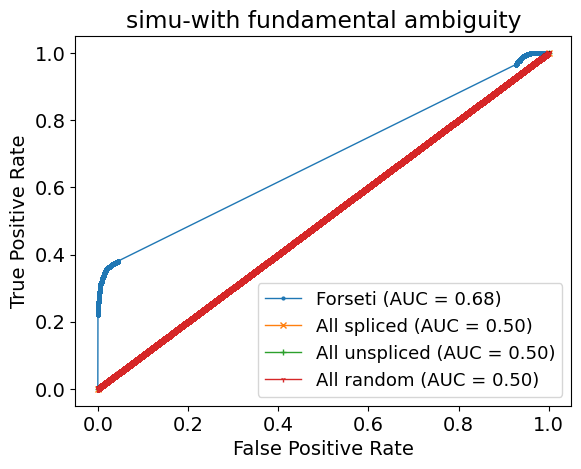

In [7]:
read_labels = np.hstack([
    np.ones(len(s2s)),
    np.ones(len(s2u)),
    np.ones(len(s2a)),
    np.zeros(len(u2s)),
    np.zeros(len(u2u)),
    np.zeros(len(u2a))
    ]
)

read_probs = np.hstack([
    np.array([p[1][0][4][1] for p in s2s]),
    np.array([p[1][0][4][1] for p in s2u]),
    np.array([p[1][0][4][1] for p in s2a]),
    np.array([p[1][0][4][1] for p in u2s]),
    np.array([p[1][0][4][1] for p in u2u]),
    np.array([p[1][0][4][1] for p in u2a])
])

read_probs_all_spliced = np.hstack([
    np.ones(len(s2s)),
    np.ones(len(s2u)),
    np.ones(len(s2a)),
    np.ones(len(u2s)),
    np.ones(len(u2u)),
    np.ones(len(u2a)),
    ]
)

read_probs_all_unspliced = np.hstack([
    np.zeros(len(s2s)),
    np.zeros(len(s2u)),
    np.zeros(len(s2a)),
    np.zeros(len(u2s)),
    np.zeros(len(u2u)),
    np.zeros(len(u2a)),
    ]
)

read_probs_rand = np.hstack([
    [random.uniform(0.5, 1) for _ in range(sum(read_labels== 1))], [random.uniform(0, 0.5) for _ in range(sum(read_labels== 0))]
])
random.shuffle( read_probs_rand )

auc_as = roc_auc_score(read_labels, read_probs_all_spliced)
fpr_as, tpr_as, _ = roc_curve(read_labels, read_probs_all_spliced)

auc_au = roc_auc_score(read_labels, read_probs_all_unspliced)
fpr_au, tpr_au, _ = roc_curve(read_labels, read_probs_all_unspliced)

auc_rand = roc_auc_score(read_labels, read_probs_rand)
fpr_rand, tpr_rand, _ = roc_curve(read_labels, read_probs_rand)

auc = roc_auc_score(read_labels, read_probs)
fpr, tpr, _ = roc_curve(read_labels, read_probs)

# save the fpr/tpr data
with open(os.path.join(out_dir, f'evaluate_simu_{allow_fa}_notA_raw_out.pkl'), "wb") as f:
    pickle.dump((fpr,tpr,fpr_as,tpr_as,fpr_au,tpr_au,fpr_rand,tpr_rand), f)

plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, marker = ".", markersize = 4, linewidth = 1, label='Forseti (AUC = %0.2f)' % auc)
plt.plot(fpr_as, tpr_as, marker = "x", markersize = 4, linewidth = 1, label='All spliced (AUC = %0.2f)' % auc_as)
plt.plot(fpr_au, tpr_au, marker = "+", markersize = 4, linewidth = 1, label='All unspliced (AUC = %0.2f)' % auc_au)
plt.plot(fpr_rand, tpr_rand, marker = "1", markersize = 4, linewidth = 1, label='All random (AUC = %0.2f)' % auc_rand)
if allow_fa:
    plt.title('simu-with fundamental ambiguity')
else:
    plt.title('simu-without fundamental ambiguity')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(fontsize = 13)
auroc_path = os.path.join(out_dir, 'AUC_ambiguous_prediction_included.jpg')
plt.savefig(auroc_path, format="jpg", bbox_inches="tight", dpi=500)
auroc_path = os.path.join(out_dir, 'AUC_ambiguous_prediction_included.pdf')
plt.savefig(auroc_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close()


AUROC without ambiguous predictions

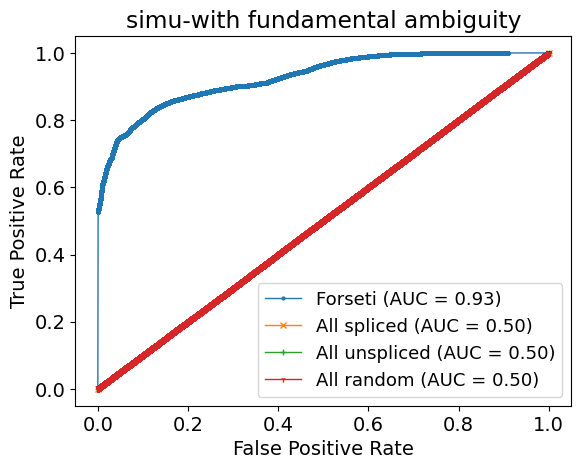

In [8]:
read_labels = np.hstack([
    np.ones(len(s2s)),
    np.ones(len(s2u)),
    np.zeros(len(u2s)),
    np.zeros(len(u2u)),
    ]
)

read_probs = np.hstack([
    np.array([p[1][0][4][1] for p in s2s]),
    np.array([p[1][0][4][1] for p in s2u]),
    np.array([p[1][0][4][1] for p in u2s]),
    np.array([p[1][0][4][1] for p in u2u]),
])

read_probs_all_spliced = np.hstack([
    np.ones(len(s2s)),
    np.ones(len(s2u)),
    np.ones(len(u2s)),
    np.ones(len(u2u)),
    ]
)

read_probs_all_unspliced = np.hstack([
    np.zeros(len(s2s)),
    np.zeros(len(s2u)),
    np.zeros(len(u2s)),
    np.zeros(len(u2u)),
    ]
)

read_probs_rand = np.hstack([
    [random.uniform(0.5, 1) for _ in range(sum(read_labels== 1))], [random.uniform(0, 0.5) for _ in range(sum(read_labels== 0))]
])
random.shuffle( read_probs_rand )

# np.array([random.random() for i in range(len(read_labels))])

auc_as = roc_auc_score(read_labels, read_probs_all_spliced)
fpr_as, tpr_as, _ = roc_curve(read_labels, read_probs_all_spliced)

auc_au = roc_auc_score(read_labels, read_probs_all_unspliced)
fpr_au, tpr_au, _ = roc_curve(read_labels, read_probs_all_unspliced)

auc_rand = roc_auc_score(read_labels, read_probs_rand)
fpr_rand, tpr_rand, _ = roc_curve(read_labels, read_probs_rand)

auc = roc_auc_score(read_labels, read_probs)
fpr, tpr, _ = roc_curve(read_labels, read_probs)

# save the fpr/tpr data
with open(os.path.join(out_dir, f'evaluate_simu_{allow_fa}_A_raw_out.pkl'), "wb") as f:
    pickle.dump((fpr,tpr,fpr_as,tpr_as,fpr_au,tpr_au,fpr_rand,tpr_rand), f)

plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, marker = ".", markersize = 4, linewidth = 1, label='Forseti (AUC = %0.2f)' % auc)
plt.plot(fpr_as, tpr_as, marker = "x", markersize = 4, linewidth = 1, label='All spliced (AUC = %0.2f)' % auc_as)
plt.plot(fpr_au, tpr_au, marker = "+", markersize = 4, linewidth = 1, label='All unspliced (AUC = %0.2f)' % auc_au)
plt.plot(fpr_rand, tpr_rand, marker = "1", markersize = 4, linewidth = 1, label='All random (AUC = %0.2f)' % auc_rand)
if allow_fa == 'allow_fa':
    plt.title('simu-with fundamental ambiguity')
else:
    plt.title('simu-without fundamental ambiguity')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(fontsize = 13)
auroc_path = os.path.join(out_dir, 'AUC_ambiguous_prediction_excluded.pdf')
plt.savefig(auroc_path, format="pdf", bbox_inches="tight")
auroc_path = os.path.join(out_dir, 'AUC_ambiguous_prediction_excluded.jpg')
plt.savefig(auroc_path, format="jpg", bbox_inches="tight", dpi=500)
plt.show()
plt.close()
